In [7]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models,layers
import matplotlib.pyplot as plt
import PIL
from PIL import ImageFile
import time
ImageFile.LOAD_TRUNCATED_IMAGES = True

Found 8820 validated image filenames belonging to 42 classes.
Found 2205 validated image filenames belonging to 42 classes.


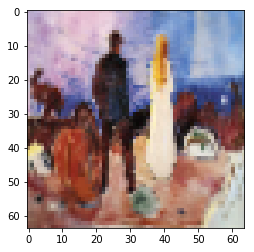

In [231]:
dataframe = pd.read_csv('paintings-data-frame.csv').astype('str')

numPixels = 64
batchSize = 1
datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255.,validation_split=0.2,rotation_range=20)
train_generator = datagen.flow_from_dataframe(dataframe=dataframe,directory='paintings-data-full', 
                                              x_col='filename',y_col='genre',subset="training",
                                              class_mode='categorical',target_size=(numPixels,numPixels),
                                              color_mode='rgb', batch_size=batchSize)

valid_generator = datagen.flow_from_dataframe(dataframe=dataframe,directory='paintings-data-full', 
                                              x_col='filename',y_col='genre',subset="validation",
                                              class_mode='categorical',target_size=(numPixels,numPixels),
                                              color_mode='rgb', batch_size=batchSize)

labels, frequencies = np.unique(train_generator.classes,return_counts=True)
num_classes = labels.shape[0]
weights = 1/frequencies

train_samples = len(train_generator.classes)
valid_samples = len(valid_generator.classes)

images,labels = train_generator.next()
num = 0
plt.imshow(images[num])
plt.show()

In [196]:
class VAE(tf.keras.Model):
    
    def __init__(self,latent_dim):
        super(VAE,self).__init__()
        self.latent_dim = latent_dim
        
        self.encoder = keras.Sequential()
        self.encoder.add(layers.Input(shape=(numPixels,numPixels,3)))
        self.encoder.add(layers.Conv2D(filters=32,kernel_size=3,strides=(2,2),activation='relu'))
        self.encoder.add(layers.Conv2D(filters=64,kernel_size=3,strides=(2,2),activation='relu'))
        self.encoder.add(layers.Flatten())
        self.encoder.add(layers.Dense(self.latent_dim + self.latent_dim))
        
        self.decoder = keras.Sequential()
        self.decoder.add(layers.Input(shape=(latent_dim,)))
        self.decoder.add(layers.Dense(8*8*32,activation='relu'))
        self.decoder.add(layers.Reshape(target_shape=(8,8,32)))
        self.decoder.add(layers.Conv2DTranspose(filters=64, kernel_size=3, strides=2, padding='same',
                activation='relu'))
        self.decoder.add(layers.Conv2DTranspose(filters=32, kernel_size=3, strides=2, padding='same',
                activation='relu'))
        self.decoder.add(layers.Conv2DTranspose(filters=16, kernel_size=3, strides=2, padding='same',
                activation='relu'))
        self.decoder.add(layers.Conv2DTranspose(filters=3, kernel_size=3, strides=1, padding='same'))
        
    
    @tf.function
    def sample(self, eps=None):
        if eps is None:
            eps = tf.random.normal(shape=(100, self.latent_dim))
        return self.decode(eps, apply_sigmoid=True)
    
    def encode(self, x):
        mean, logvar = tf.split(self.encoder(x), num_or_size_splits=2, axis=1)
        return mean, logvar  
    
    def reparameterize(self, mean, logvar):
        eps = tf.random.normal(shape=mean.shape)
        return eps * tf.exp(logvar * .5) + mean
    
    def decode(self, z, apply_sigmoid=False):
        logits = self.decoder(z)
        if apply_sigmoid:
            probs = tf.sigmoid(logits)
            return probs
        return logits
    
optimizer = tf.keras.optimizers.Adam(1e-4)

def log_normal_pdf(sample,mean,logvar,raxis=1):
    log2pi = tf.math.log(2.*np.pi)
    return tf.reduce_sum(-.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi),axis=raxis)

def compute_loss(model, x):
    mean, logvar = model.encode(x)
    z = model.reparameterize(mean, logvar)
    x_logit = model.decode(z)
    cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=x)
    logpx_z = -tf.reduce_sum(cross_ent, axis=[1, 2, 3])
    logpz = log_normal_pdf(z, 0., 0.)
    logqz_x = log_normal_pdf(z, mean, logvar)
    return -tf.reduce_mean(logpx_z + logpz - logqz_x)

        
@tf.function
def train_step(model, x, optimizer):
    with tf.GradientTape() as tape:
        loss = compute_loss(model, x)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
   

In [197]:
latent_dim = 2
model = VAE(latent_dim)

In [277]:
epochs = 10
steps_per_epoch = train_samples

for epoch in range(1, epochs + 1):
    start_time = time.time()
    for i in range(steps_per_epoch):
        train_step(model, train_generator.next()[0], optimizer)
    end_time = time.time()
    print("Time for Epoch ",epoch,"= ",end_time-start_time)

    loss = tf.keras.metrics.Mean()
    for i in range(10):
        loss(compute_loss(model, valid_generator.next()[0]))
    elbo = -loss.result()
    print("Sampled validation loss = ",elbo)


Time for Epoch  1 =  226.76419711112976
Sampled validation loss =  tf.Tensor(-7923.6577, shape=(), dtype=float32)
Time for Epoch  2 =  232.59895610809326
Sampled validation loss =  tf.Tensor(-7807.1455, shape=(), dtype=float32)
Time for Epoch  3 =  2073.7355308532715
Sampled validation loss =  tf.Tensor(-7509.311, shape=(), dtype=float32)
Time for Epoch  4 =  230.48617887496948
Sampled validation loss =  tf.Tensor(-7471.824, shape=(), dtype=float32)
Time for Epoch  5 =  225.33006596565247
Sampled validation loss =  tf.Tensor(-7405.203, shape=(), dtype=float32)
Time for Epoch  6 =  229.3321828842163
Sampled validation loss =  tf.Tensor(-7496.264, shape=(), dtype=float32)
Time for Epoch  7 =  227.55456686019897
Sampled validation loss =  tf.Tensor(-7392.225, shape=(), dtype=float32)
Time for Epoch  8 =  227.2836139202118
Sampled validation loss =  tf.Tensor(-7478.258, shape=(), dtype=float32)
Time for Epoch  9 =  224.03408002853394
Sampled validation loss =  tf.Tensor(-7587.478, shape=()

KeyboardInterrupt: 

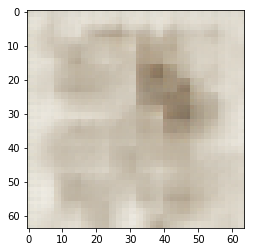

In [287]:
plt.imshow(model.sample(tf.constant([[-10,-3]]))[0])

In [ ]:
def generate_and_save_images(model, epoch, test_sample):
    mean, logvar = model.encode(test_sample)
    z = model.reparameterize(mean, logvar)
    predictions = model.sample(z)
    fig = plt.figure(figsize=(4, 4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i + 1)
        plt.imshow(predictions[i, :, :, 0], cmap='gray')
        plt.axis('off')

    # tight_layout minimizes the overlap between 2 sub-plots
    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()
